This notebook shows an example of how to conduct a point-source analysis.
The core of the analysis is a binned poisson likelihood evaluation using Asimov data.
The histograms of the analysis are the effective area, the energy resolution, the angular resolution and the atmospheric background model.
Core functions of the PLEnuM software are used in this example.

In [1]:
%load_ext autoreload
%autoreload 2

# Preparations

This notebook uses the full PLEnuM tool. See installation notes here:

https://github.com/PLEnuM-group/Plenum/tree/dev#readme

In [2]:
# need to run once in the beginning to prepare all ingredients for the analysis
# this might take several minutes

# run these only if you haven't done so before
# load IceCube's effective area and rotate it to approximate other detectors
# %run ../../core/aeff_calculations.py

# calculate the atmospheric neutrino background using MCEq (IceCube-centric)
# %run ../../core/atmospheric_background.py

# run these every time there are updates to resolution, binning, or mephistograms
# load and prepare the energy and angular resolutions
# %run ../../core/resolution.py

# gather all ingredients and save them as unified 'mephistogram' data structure
# %run ../../core/prepare_histograms.py

# Imports

In [3]:
import pickle
from collections import namedtuple
from copy import copy
from os.path import join

import numpy as np
import seaborn as sns

plt = sns.mpl.pyplot
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
)
import mephisto
from matplotlib.colors import LogNorm
from scipy.optimize import fmin_l_bfgs_b
from scipy.stats import chi2, norm
import settings as st
from tools import array_source_interp
from likelihood import poisson_llh, ps_llh_single, ps_llh_multi, setup_multi_llh

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


# Default binning

In [4]:
print(len(st.logE_bins), np.min(st.logE_bins), np.max(st.logE_bins))
print(len(st.logE_reco_bins), np.min(st.logE_reco_bins), np.max(st.logE_reco_bins))
print(len(st.sindec_bins), np.min(st.sindec_bins), np.max(st.sindec_bins))


141 2.0 8.999999999999975
140 2.0 8.949999999999974
101 -1.0 1.0


# Source parameters

In [5]:
# livetime of 10yrs in seconds and days
print(st.LIVETIME, st.LIVETIME / 24 / 3600)
# Normalization energy of power law (E/E_NORM)^GAMMA_ASTRO
print(st.E_NORM)  # in GeV
# Source flux spectral index
# see https://arxiv.org/abs/2111.10299?context=astro-ph
print(st.GAMMA_ASTRO)  # spectral index
print(st.PHI_ASTRO)  # neutrinos * (E/E_NORM)^GAMMA_ASTRO / GeV / cm^2 / s / sr
print(st.BASEPATH)
print(st.LOCALPATH)


275270400 3186.0
100000.0
2.37
1.44e-18
/home/hpc/capn/capn102h/repos/Plenum
/home/hpc/capn/capn102h/repos/Plenum/local


# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

dict_keys(['Plenum-1', 'IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD', 'Gen-2', 'Plenum-2'])
Mephistogram with 2 dimensions and shape (100, 140). Axis names are ('sin(dec)', 'log(E/GeV)').
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [13.89052107 13.89052107 17.29089572 ... 53.13487989 16.34349946
  12.60576569]
 [17.34743125 17.34743125 20.90008048 ... 30.07349802 15.69161799
  12.10296853]
 [19.09667171 19.09667171 22.72645289 ... 18.40139186 15.42392107
  11.89649349]]


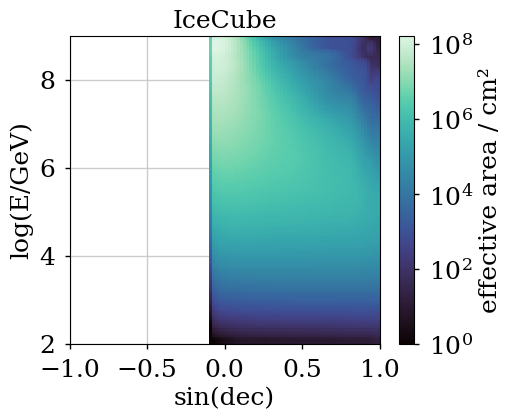

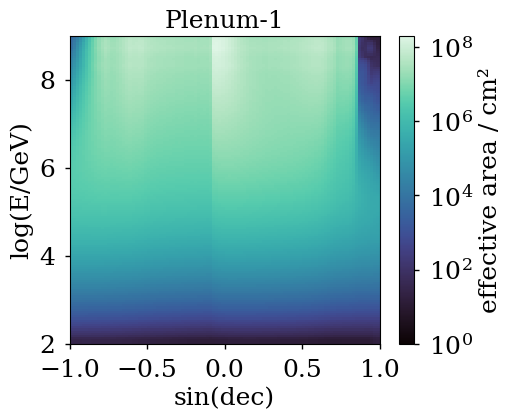

In [6]:
with open(join(st.LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)
print(aeff_2d.keys())
print(aeff_2d["IceCube"])  # mephistogram data structure for histograms+binning

# plot the effective area
for key in ["IceCube", "Plenum-1"]:
    mephisto.plot_mephistogram(aeff_2d[key], norm=LogNorm(vmin=1))
    cb = plt.gca().collections[0].colorbar
    cb.set_label("effective area / cm²")
    plt.title(key)


# Background

Elementary arithmetic possible.
True


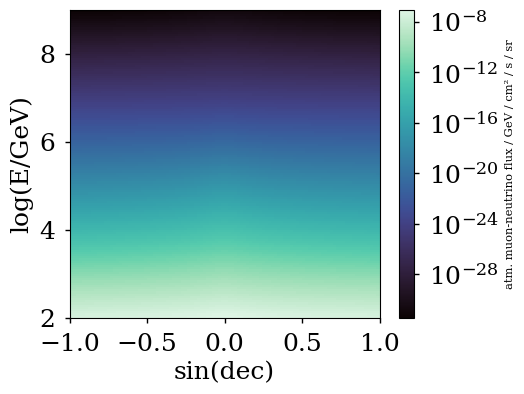

In [7]:
# MCEQ: atmospheric flux on muon neutrinos (see also 'background_flux.ipynb')
with open(join(st.LOCALPATH, "atmospheric_background_daemonflux_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# check if histograms are matching, i.e. have the same binning
print(bckg_histo["IceCube"].match(aeff_2d["IceCube"], verbose=True))

# visualization of bckg flux
mephisto.plot_mephistogram(bckg_histo["IceCube"], norm=LogNorm())
cb = plt.gca().collections[0].colorbar
cb.set_label("atm. muon-neutrino flux / GeV / cm² / s / sr", fontsize="small")


# Energy smearing

In [8]:
from matplotlib.colors import ListedColormap, LogNorm
cmap = ListedColormap(sns.color_palette("mako", n_colors=10))

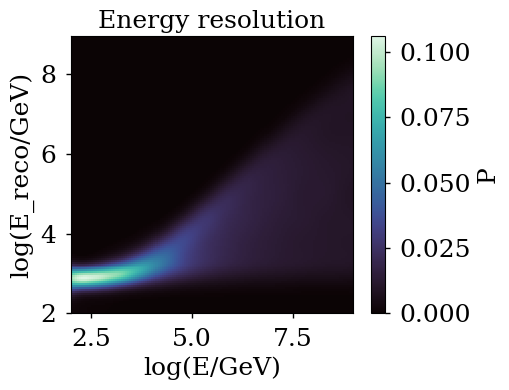

In [9]:
# energy smearing matrix
with open(join(st.LOCALPATH, "energy_smearing_GP_up.pckl"), "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize(axis=1)

# artificially improved
with open(join(st.LOCALPATH, "improved_0.5_artificial_energy_smearing_GP_up.pckl"), "rb") as f:
    improved_eres = pickle.load(f)
improved_eres.normalize(axis=1)

f, ax = mephisto.plot_mephistogram(baseline_eres)#, cmap=cmap, vmax=0.1, vmin=0)
cb = plt.gca().collections[0].colorbar
cb.set_label("P")
ax.set_title("Energy resolution")
f.tight_layout()
#f.savefig("../../plots/eres-icecube.png")

# Psi²-Energy resolution

NOTE: psi changes per detector over the day. For the sake of (optimistic) simplicity, we choose the horizontal resolution for all detectors

In [10]:
# angular resolution
with open(join(st.LOCALPATH, f"Psi2-{st.delta_psi_max}_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
e_psi2_grid = all_psi["dec-0.0"]
e_psi2_grid.normalize()

# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()

Text(0.5, 1.0, 'angular resolution')

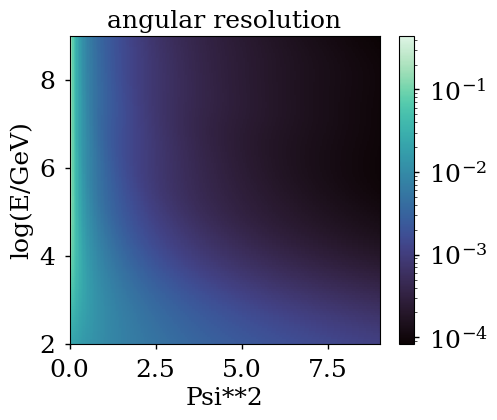

In [26]:
e_psi2_grid.plot(norm=LogNorm())
plt.title("angular resolution")

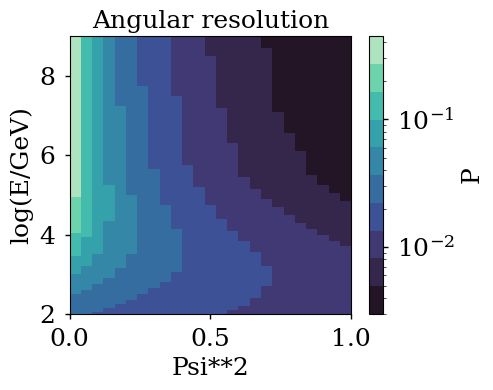

In [11]:
f, ax = mephisto.plot_mephistogram(e_psi2_grid, norm=LogNorm(vmin=3E-3), cmap=cmap)
cb = plt.gca().collections[0].colorbar
cb.set_label("P")
ax.set_xlim(0, 1)
ax.set_title("Angular resolution")
f.tight_layout()
#f.savefig("../../plots/psi2res-icecube.png")

# Source flux definition
$N_{\nu} = T_{\rm live} \cdot \int_{\Delta \Omega} d \Omega \, d E \, \int_{E_{\min}}^{E_{\max}} dE \, A_{\rm eff} \left( E, \sin(\delta)\right) \cdot \frac{d \Phi}{d E} $

Approximate the integral with a finite-binning approach:

aeff_factor =
$ 2\pi \cdot \Delta \sin (\delta) \, \Delta E \cdot A_{\rm eff} \left( E, \sin(\delta)\right) $ 

($2\pi = \int_0^{2\pi} d\phi$; $d \Omega = d \phi \cdot d \sin(\delta)$)

In [12]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
ngc_flux = PL_flux(st.PHI_NGC, st.GAMMA_NGC, st.E0_NGC, "powerlaw")


In [13]:
# ngc1068 source config
ngc_src_config = dict(
    sindec_mids=st.sindec_mids,
    livetime=st.LIVETIME,
    ewidth=st.ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
    dec=st.ngc1068.dec.rad,
)
# corresponding bg config
ngc_bg_config = copy(ngc_src_config)
ngc_bg_config["dpsi_max"] = st.delta_psi_max
ngc_bg_config["grid_2d"] = bckg_psi2_grid



## Check event numbers

In [14]:
ident = "IceCube"
# check that the bins match
assert (aeff_2d[ident].bins[1] == ngc_src_config["grid_2d"].bins[1]).all()
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

k_s = astro_flux(
    aeff_factor_signal,
    10**aeff_factor_signal.bin_mids[1],
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("ngc 1068:", np.sum(k_s))  # ~85


ngc 1068: 88.11995358931372


# Asimov histograms in Psi² - log(E)

Fit parameters for analysis:
* Global normalization of k_b
* Global normalization of k_s
* Spectral index of k_s (=gamma)

In [15]:
ident = "IceCube"

aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

# asimov data
k_b = atmo_background(
    aeff_factor=aeff_factor_bckg,
    bckg_vals=array_source_interp(
        ngc_src_config["dec"], bckg_histo["IceCube"], st.sindec_mids, axis=1
    ),
    energy_resolution=baseline_eres,
)
# power law
k_s = astro_flux(
    aeff_factor=aeff_factor_signal,
    emids=10**aeff_factor_signal.bin_mids[1],
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,  # powerlaw
)
k_i = k_s + k_b

print("Asimov data sum:")
print("Background:", np.sum(k_b))  # ~1170
print("Signal:", np.sum(k_s))  # ~85
print("S+B", np.sum(k_i))

Asimov data sum:
Background: 1311.1901878294507
Signal: 88.11995358931372
S+B 1399.3101414187647


In [16]:
print(k_s) # mephistogram data structure for histograms+binning

Mephistogram with 2 dimensions and shape (225, 139). Axis names are ('Psi**2', 'log(E_reco/GeV)').
[[9.66298660e-04 1.12238285e-03 1.28997401e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.64388630e-04 9.99325430e-04 1.14340066e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.77665822e-04 8.97279186e-04 1.02477881e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.10467405e-05 2.34374802e-05 2.59531986e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.08998557e-05 2.32734820e-05 2.57712462e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.07544771e-05 2.31111723e-05 2.55911728e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


## Plotting the histograms

Text(0.5, 1.0, 'Signal astrophysical flux')

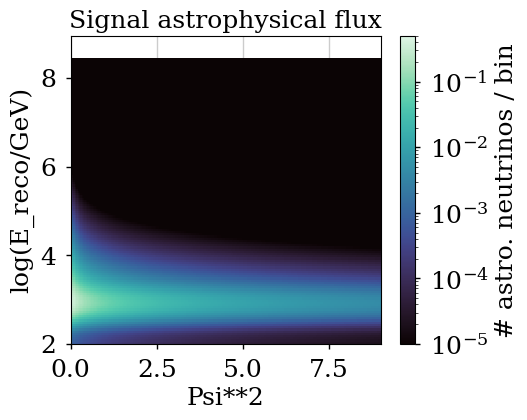

In [17]:
## signal
k_s.plot(norm=LogNorm(vmin=1E-5))
cb = plt.gca().collections[0].colorbar
cb.set_label("# astro. neutrinos / bin")
plt.title("Signal astrophysical flux")

Text(0.5, 1.0, 'Background atmospheric flux')

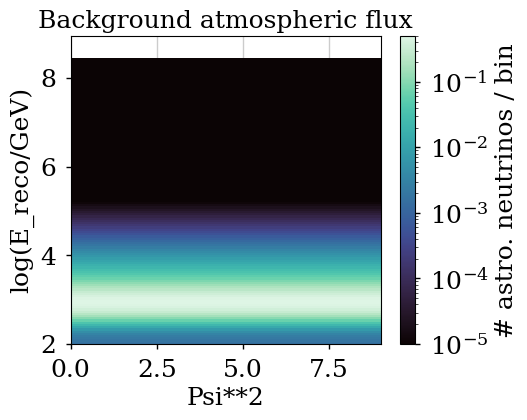

In [18]:
## background
k_b.plot(norm=LogNorm(vmin=1E-5))
cb = plt.gca().collections[0].colorbar
cb.set_label("# astro. neutrinos / bin")
plt.title("Background atmospheric flux")

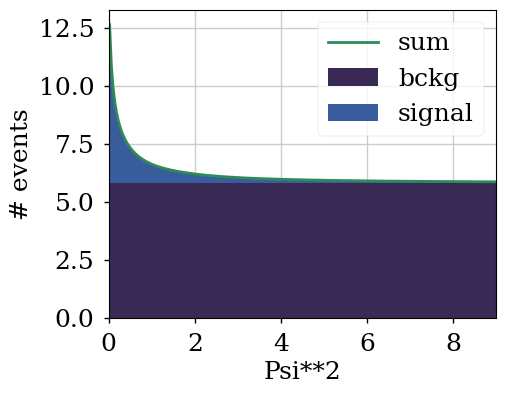

In [19]:
# summed 1D hist in psi²
f, axes = plt.subplots(figsize=(5, 4))
mephisto.plot_multiple_mephistograms(
    (k_b.sum(axis=1, return_mephisto=True), k_s.sum(axis=1, return_mephisto=True)),
    labels=["bckg", "signal"],
    f=f,
    axes=axes,
)
k_i_en = k_i.sum(axis=1, return_mephisto=True)
plt.plot(k_i_en.bin_mids, k_i_en.histo, label="sum", color="seagreen")

plt.ylabel("# events")
plt.legend()

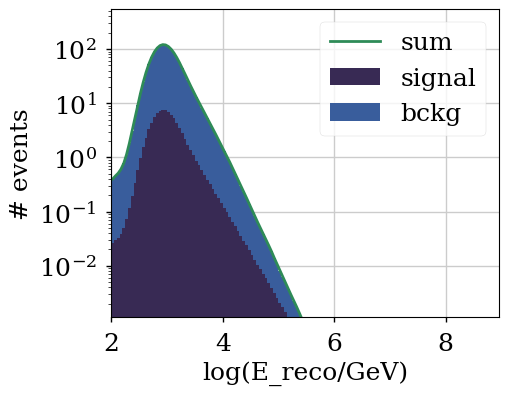

In [20]:
# summed 1D hist in log(E_reco)
f, axes = plt.subplots(figsize=(5, 4))
mephisto.plot_multiple_mephistograms(
    (k_s.sum(axis=0, return_mephisto=True), k_b.sum(axis=0, return_mephisto=True)),
    labels=["signal", "bckg"],
    f=f,
    axes=axes,
)
k_i_en = k_i.sum(axis=0, return_mephisto=True)
plt.plot(k_i_en.bin_mids, k_i_en.histo, label="sum", color="seagreen")

plt.yscale("log")
plt.ylabel("# events")
plt.legend()

# DEMO: Significance test 
Background vs. Background + Signal

## Do the fit

In [21]:
ident = "IceCube"

aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

# asimov data
bckg_flux = array_source_interp(
    ngc_src_config["dec"], bckg_histo[ident], st.sindec_mids, axis=1
)

k_b = atmo_background(
    aeff_factor=aeff_factor_bckg,
    bckg_vals=bckg_flux,
    energy_resolution=baseline_eres,
)
# power law
k_s = astro_flux(
    aeff_factor=aeff_factor_signal,
    emids=10**aeff_factor_signal.bin_mids[1],
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,  # powerlaw
)
k_i = k_s + k_b

print("Asimov data sum:")
print("Background:", np.sum(k_b))
print("Signal:", np.sum(k_s))

dct = dict(
    aeff_factor_s=aeff_factor_signal,
    aeff_factor_b=aeff_factor_bckg,
    k_i=k_i,
    bckg_flux=bckg_flux,
    energy_resolution=baseline_eres,
    e_0=ngc_flux.E0,
    phi_0=ngc_flux.norm,
    shape="powerlaw"
)

# fix signal normalization to 0
local_llh = lambda x: ps_llh_single((x[0], 0, 3), **dct)
global_llh = lambda x: ps_llh_single(x, **dct)

out_bckg = fmin_l_bfgs_b(
    local_llh,
    x0=(1,),
    approx_grad=True,
)
print("Atmo-only normalization:", out_bckg[0])

# this fit is not really needed, but good for crosschecking the code
out_comp = fmin_l_bfgs_b(
    global_llh,
    x0=(1, 1, ngc_flux.gamma),
    approx_grad=True,
)
print("Signal fit parameters:", out_comp[0])
print("TS check:", global_llh((1, 1, ngc_flux.gamma)), "(fit: ", out_comp[1], ")")
print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
significance = norm.isf(pval)
print("P-VALUE:", pval, "SIGNIFICANCE:", significance)


Asimov data sum:
Background: 1311.1901878294507
Signal: 88.11995358931372
Atmo-only normalization: [1.06719847]
Signal fit parameters: [1.  1.  3.2]
TS check: -307073.7773538268 (fit:  -307073.7773538268 )
-2 Delta LLH: 19.847150375542697
P-VALUE: 4.9005638856463895e-05 SIGNIFICANCE: 3.8954631141269993


## multi llh with one data set
cross check to above 

In [22]:
conf = (["IceCube"], [1])  # 1 IceCube unit (~10 years)
(
    all_aeff_factor_s,
    all_aeff_factor_b,
    all_k,
    all_bckg_flux,
    all_eres,
) = setup_multi_llh(
    eres=baseline_eres,
    conf=conf,
    aeff_2d=aeff_2d,
    src_flux=ngc_flux,
    bckg_histo=bckg_histo,
    bg_config=ngc_bg_config,
    sig_config=ngc_src_config,
)

dct = dict(
    shape="powerlaw",
    all_aeff_factor_s=all_aeff_factor_s,
    all_aeff_factor_b=all_aeff_factor_b,
    all_k=all_k,
    all_bckg_flux=all_bckg_flux,
    all_eres=all_eres,
    e_0=ngc_flux.E0,
    phi_0=ngc_flux.norm,
)

# fix signal normalization to 0
local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
global_llh = lambda x: ps_llh_multi(x, **dct)

out_bckg = fmin_l_bfgs_b(
    local_llh,
    x0=(1,),
    approx_grad=True,
)
print("Atmo-only normalization:", out_bckg[0])

# this fit is not really needed, but good for crosschecking the code
out_comp = fmin_l_bfgs_b(
    global_llh,
    x0=(1, 1, ngc_flux.gamma),
    approx_grad=True,
)
print("Signal fit parameters:", out_comp[0])
print("TS check:", global_llh((1, 1, ngc_flux.gamma)), "(fit: ", out_comp[1], ")")
print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
significance = norm.isf(pval)
print("P-VALUE:", pval, "SIGNIFICANCE:", significance)

Atmo-only normalization: [1.06719847]
Signal fit parameters: [1.  1.  3.2]
TS check: -307073.7773538268 (fit:  -307073.7773538268 )
-2 Delta LLH: 19.847150375542697
P-VALUE: 4.9005638856463895e-05 SIGNIFICANCE: 3.8954631141269993


## multi llh with 2 sets

In [23]:
conf = (["IceCube", "P-ONE"], [1, 1])  # 1 IceCube and 1 P-ONE unit each
# different energy resolutions per detector
eres_conf = {"IceCube": baseline_eres, "P-ONE": improved_eres}


(
    all_aeff_factor_s,
    all_aeff_factor_b,
    all_k,
    all_bckg_flux,
    all_eres,
) = setup_multi_llh(
    eres=eres_conf,
    conf=conf,
    aeff_2d=aeff_2d,
    src_flux=ngc_flux,
    bckg_histo=bckg_histo,
    bg_config=ngc_bg_config,
    sig_config=ngc_src_config,
)

dct = dict(
    shape="powerlaw",
    all_aeff_factor_s=all_aeff_factor_s,
    all_aeff_factor_b=all_aeff_factor_b,
    all_k=all_k,
    all_bckg_flux=all_bckg_flux,
    all_eres=all_eres,
    e_0=ngc_flux.E0,
    phi_0=ngc_flux.norm,
)

# fix signal normalization to 0
local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
global_llh = lambda x: ps_llh_multi(x, **dct)

out_bckg = fmin_l_bfgs_b(
    local_llh,
    x0=(1,),
    approx_grad=True,
)
print("Atmo-only normalization:", out_bckg[0])

# this fit is not really needed, but good for crosschecking the minimization
out_comp = fmin_l_bfgs_b(
    global_llh,
    x0=(1, 1, ngc_flux.gamma),
    approx_grad=True,
)
print("Signal fit parameters:", out_comp[0])
print("TS check:", global_llh((1, 1, ngc_flux.gamma)), "(fit: ", out_comp[1], ")")
print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
significance = norm.isf(pval)
print("P-VALUE:", pval, "SIGNIFICANCE:", significance)

Atmo-only normalization: [1.08560532]
Signal fit parameters: [1.  1.  3.2]
TS check: -644160.3518404067 (fit:  -644160.3518404067 )
-2 Delta LLH: 45.241793844266795
P-VALUE: 1.499233545432608e-10 SIGNIFICANCE: 6.29885790170519
